In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as TVdatasets

import torchattacks

from tqdm.notebook import tqdm

### Define device type

In [2]:
# define device type - cuda or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device == torch.device("cuda") else {}

### Load CIFAR-10 data

In [3]:
def load_CIFAR10_data(train_batch_size, test_batch_size, kwargs):
    cifar10_transform = transforms.Compose([transforms.ToTensor(),
                                           transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

    cifar10_train_data = TVdatasets.CIFAR10(root="../data/", 
                                            train=True, 
                                            download=True, 
                                            transform=cifar10_transform)

    cifar10_test_data = TVdatasets.CIFAR10(root="../data/", 
                                           train=False, 
                                           download=True, 
                                           transform=cifar10_transform)

    print("Number of train samples:", len(cifar10_train_data))
    print("Number of test samples:", len(cifar10_test_data))

    trainloader = torch.utils.data.DataLoader(dataset=cifar10_train_data,
                                             batch_size=train_batch_size,
                                             shuffle=True,
                                             **kwargs)

    testloader = torch.utils.data.DataLoader(dataset=cifar10_test_data,
                                             batch_size=test_batch_size,
                                             shuffle=False,
                                            **kwargs)
    
    return trainloader, testloader

### Model definition

In [8]:
class CNN_net(nn.Module):
    def __init__(self):
        super(CNN_net, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)    
        )
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*5*5)
        out = self.fc_layer(out)
        
        return out

### Adversarial Training Process

In [6]:
def adversarial_training(model, trainloader, attack, num_epochs, stepsize):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=stepsize)
    
    num_batches = len(trainloader)
    loss_lst = []

    for epoch in range(num_epochs):
        for itr, (batch_imgs, batch_labels) in enumerate(tqdm(trainloader)):
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            batch_adv_imgs = pgd_attack(batch_imgs, batch_labels)

            X_train = torch.cat((batch_adv_imgs, batch_imgs), 0)   
            Y_train_gt = torch.cat((batch_labels, batch_labels), 0)

    #         X_train = batch_imgs
    #         Y_train_gt = batch_labels

            Y_train_pred = model(X_train)
            loss_val = loss(Y_train_pred, Y_train_gt)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            if (itr + 1) % 100 == 0:
                print("Epoch [{}/{}], Iteration [{}/{}], Loss:{}".format(epoch+1, num_epochs, 
                                                                            itr+1, num_batches, 
                                                                            round(loss_val.item(),4)))

            loss_lst.append(loss_val.item())
    
    plt.figure(figsize=(10,7))
    plt.plot(loss_lst)
    plt.xlabel("iteration")
    plt.ylabel("objective function")
    plt.grid()
    plt.show()

    model_save_path = '../saved_models/cifar10_net.pth'
    torch.save(model.state_dict(), model_save_path)

### Load model and data

In [9]:
train_batch_size = 32
test_batch_size = 32

model = CNN_net().to(device)
# model.load_state_dict(torch.load("./checkpoint/holdout.pth"))
# model = model.eval().cuda()

trainloader, testloader = load_CIFAR10_data(train_batch_size, test_batch_size, kwargs)

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


### Define attack model

In [10]:
adv_eps = 8/255
adv_pgd_steps = 10

pgd_attack = torchattacks.PGD(model, eps=adv_eps, alpha=2/255, steps=adv_pgd_steps)
fgsm_attack = torchattacks.FGSM(model, eps=adv_eps)

In [11]:
# pgd_attack = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=10)
# pgd_attack.set_return_type('int')
# pgd_attack.save(data_loader=testloader, save_path="./data/cifar10_pgd.pt", verbose=True)

In [12]:
# adv_imgs, adv_labels = torch.load("./data/cifar10_pgd.pt")
# adv_data = TensorDataset(adv_imgs.float() / 255.0, adv_labels)
# adv_loader = torch.utils.data.DataLoader(adv_data, batch_size=128, shuffle=False)

### Adversarial Training

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [1/5], Iteration [100/1563], Loss:1.9118
Epoch [1/5], Iteration [200/1563], Loss:1.8114
Epoch [1/5], Iteration [300/1563], Loss:1.505
Epoch [1/5], Iteration [400/1563], Loss:1.8964
Epoch [1/5], Iteration [500/1563], Loss:1.9425
Epoch [1/5], Iteration [600/1563], Loss:1.5345
Epoch [1/5], Iteration [700/1563], Loss:1.6475
Epoch [1/5], Iteration [800/1563], Loss:1.7871
Epoch [1/5], Iteration [900/1563], Loss:1.2852
Epoch [1/5], Iteration [1000/1563], Loss:1.6328
Epoch [1/5], Iteration [1100/1563], Loss:1.5498
Epoch [1/5], Iteration [1200/1563], Loss:1.4162
Epoch [1/5], Iteration [1300/1563], Loss:1.4956
Epoch [1/5], Iteration [1400/1563], Loss:1.5655
Epoch [1/5], Iteration [1500/1563], Loss:1.4077


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [2/5], Iteration [100/1563], Loss:1.3589
Epoch [2/5], Iteration [200/1563], Loss:1.7272
Epoch [2/5], Iteration [300/1563], Loss:1.4592
Epoch [2/5], Iteration [400/1563], Loss:1.4477
Epoch [2/5], Iteration [500/1563], Loss:1.2064
Epoch [2/5], Iteration [600/1563], Loss:1.6314
Epoch [2/5], Iteration [700/1563], Loss:1.7045
Epoch [2/5], Iteration [800/1563], Loss:1.1912
Epoch [2/5], Iteration [900/1563], Loss:1.4219
Epoch [2/5], Iteration [1000/1563], Loss:1.3285
Epoch [2/5], Iteration [1100/1563], Loss:1.5408
Epoch [2/5], Iteration [1200/1563], Loss:1.667
Epoch [2/5], Iteration [1300/1563], Loss:1.2589
Epoch [2/5], Iteration [1400/1563], Loss:1.242
Epoch [2/5], Iteration [1500/1563], Loss:1.255


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [3/5], Iteration [100/1563], Loss:1.4616
Epoch [3/5], Iteration [200/1563], Loss:1.2646
Epoch [3/5], Iteration [300/1563], Loss:1.4189
Epoch [3/5], Iteration [400/1563], Loss:1.2719
Epoch [3/5], Iteration [500/1563], Loss:1.5972
Epoch [3/5], Iteration [600/1563], Loss:1.3947
Epoch [3/5], Iteration [700/1563], Loss:1.3549
Epoch [3/5], Iteration [800/1563], Loss:1.3335
Epoch [3/5], Iteration [900/1563], Loss:1.3112
Epoch [3/5], Iteration [1000/1563], Loss:1.0926
Epoch [3/5], Iteration [1100/1563], Loss:1.1605
Epoch [3/5], Iteration [1200/1563], Loss:1.3441
Epoch [3/5], Iteration [1300/1563], Loss:1.3095
Epoch [3/5], Iteration [1400/1563], Loss:1.1173
Epoch [3/5], Iteration [1500/1563], Loss:1.2851


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [4/5], Iteration [100/1563], Loss:1.6312
Epoch [4/5], Iteration [200/1563], Loss:1.2717
Epoch [4/5], Iteration [300/1563], Loss:1.1208
Epoch [4/5], Iteration [400/1563], Loss:1.3447
Epoch [4/5], Iteration [500/1563], Loss:1.5006
Epoch [4/5], Iteration [600/1563], Loss:0.9425
Epoch [4/5], Iteration [700/1563], Loss:1.3054
Epoch [4/5], Iteration [800/1563], Loss:1.335
Epoch [4/5], Iteration [900/1563], Loss:1.271
Epoch [4/5], Iteration [1000/1563], Loss:1.2033
Epoch [4/5], Iteration [1100/1563], Loss:1.2856
Epoch [4/5], Iteration [1200/1563], Loss:1.0153
Epoch [4/5], Iteration [1300/1563], Loss:1.3427
Epoch [4/5], Iteration [1400/1563], Loss:1.0262
Epoch [4/5], Iteration [1500/1563], Loss:1.2097


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [5/5], Iteration [100/1563], Loss:1.3548
Epoch [5/5], Iteration [200/1563], Loss:1.5967
Epoch [5/5], Iteration [300/1563], Loss:1.3355
Epoch [5/5], Iteration [400/1563], Loss:1.3902
Epoch [5/5], Iteration [500/1563], Loss:1.3313
Epoch [5/5], Iteration [600/1563], Loss:0.9884
Epoch [5/5], Iteration [700/1563], Loss:0.9408
Epoch [5/5], Iteration [800/1563], Loss:1.0771
Epoch [5/5], Iteration [900/1563], Loss:1.0362
Epoch [5/5], Iteration [1000/1563], Loss:1.3211
Epoch [5/5], Iteration [1100/1563], Loss:1.474
Epoch [5/5], Iteration [1200/1563], Loss:1.5399
Epoch [5/5], Iteration [1300/1563], Loss:1.354
Epoch [5/5], Iteration [1400/1563], Loss:0.9182
Epoch [5/5], Iteration [1500/1563], Loss:1.0243


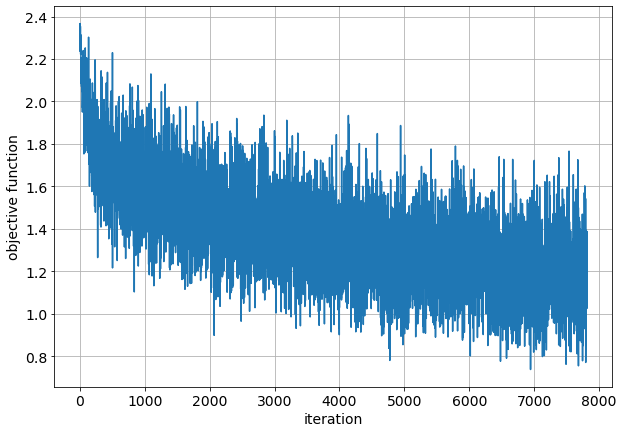

In [13]:
adversarial_training(model, trainloader, pgd_attack, num_epochs=5, stepsize=1e-3)

### Test accuracy (standard clean)

In [14]:
num_samples = 0
num_corr_pred = 0
model.eval()

with torch.no_grad():
    for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
        batch_imgs = batch_imgs.to(device)
        batch_labels = batch_labels.to(device)
#         print(batch_imgs.shape, batch_labels.shape)

        X_test = batch_imgs
        Y_test_gt = batch_labels

        _, Y_test_pred = torch.max(model(X_test), dim=1)

        num_samples += batch_imgs.shape[0]
        num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Standard clean accuracy: {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Standard clean accuracy: 70.42 %


### Test accuracy (PGD attack)

In [15]:
num_samples = 0
num_corr_pred = 0
model.eval()

# with torch.no_grad():
for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
#     print(batch_imgs.shape, batch_labels.shape)

    X_adv_pgd_imgs = pgd_attack(batch_imgs, batch_labels)

    X_test = X_adv_pgd_imgs
    Y_test_gt = batch_labels

    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()
    
test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (PGD attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (PGD attack): 38.14 %


### Test accuracy (FGSM attack)

In [16]:
num_samples = 0
num_corr_pred = 0
model.eval()

# with torch.no_grad():
for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
#     batch_imgs = transforms.functional.rgb_to_grayscale(batch_imgs, num_output_channels=1) 
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
#     print(batch_imgs.shape, batch_labels.shape)

    X_adv_fgsm_imgs = fgsm_attack(batch_imgs, batch_labels)

    X_test = X_adv_fgsm_imgs
    Y_test_gt = batch_labels

    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()
    
test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (FGSM attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (FGSM attack): 46.51 %


### Test accuracy (FGSM + PGD attack)

In [17]:
num_samples = 0
num_corr_pred = 0
model.eval()

for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
    
    X_adv_fgsm_imgs = fgsm_attack(batch_imgs, batch_labels)
    X_adv_pgd_imgs = pgd_attack(batch_imgs, batch_labels)
    
    X_test = torch.cat((X_adv_fgsm_imgs, X_adv_pgd_imgs), 0)
    Y_test_gt = torch.cat((batch_labels, batch_labels), 0)
    
    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += Y_test_gt.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (FGSM + PGD attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (FGSM + PGD attack): 42.31 %
